# Анализ убытков развлекательного приложения

**Описание проекта**: развлекательное приложение делает огромные вложения в рекламу, но последние несколько месяцев терпит убытки. 

**Задачи**: 
- найти причины, по которым компания терпит убытки, 
- дать рекомендации, благодаря которым компания сможет выйти в плюс.

**Стратегия анализа**:

 - изучить откуда приходят пользователи и какими устройствами они пользуются;
 - посмотреть сколько стоит привлечение пользователей из различных рекламных каналов;
 - составить профили пользователей и проанализировать основные метрики юнит-экономики (LTV, CAC, NOI);
 - использовать когортный анализ и функции расчёта метрик;
 - сделать вывод о причинах убытков на основе подсчитанных показателей и построенных графиков.
 - дать рекомендации.

**Описание данных**

Есть три датасета. 
Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, 
`orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

*Структура `visits_info_short.csv`*:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

*Структура `orders_info_short.csv`*:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

*Структура `costs_info_short.csv`*:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

### Загружаем данные и готовим их к анализу

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загружаем данные
visits = pd.read_csv('/datasets/visits_info_short.csv') # журнал сессий
orders = pd.read_csv('/datasets/orders_info_short.csv') # заказы
costs = pd.read_csv('/datasets/costs_info_short.csv') # рекламные расходы

# проверяем данные на пропуски и типы данных
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [3]:
# переводим даты в нужный формат
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

In [4]:
# делаем названия колонок более читабельными
visits.rename(columns=str.lower, inplace=True) 
visits = visits.rename(columns = {'user id' : 'user_id',
                'session start' : 'session_start',
                'session end' : 'session_end'})
orders.rename(columns=str.lower, inplace=True) 
orders = orders.rename(columns = {'user id' : 'user_id',
                'event dt' : 'event_dt'})
costs.rename(columns=str.lower, inplace=True) 
# проверка
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [5]:
# проверка на дубликаты
display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()

0

0

0

In [6]:
# проверка на дубликаты столбцов с категорийными значениями
display(visits['region'].unique())
display(visits['device'].unique())
display(visits['channel'].unique())
costs['channel'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Выводы:
- Пропуски и дубликаты в данных не обнаружены. Были рассмотрены полные дубликаты и дубликаты в категорийных столбцах. 
- Были изменены типы данных в столбцах со временем. 
- Имена колонок были приведены к единому стилю.

### Задаем функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Здесь представлен список всех функций, которые будут использованы далее в исследовании.

#### Профили

In [7]:
# функция для создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):

    # параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


#### Удержание

In [8]:
# функция для подсчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Конверсия

In [9]:
# функция для определения конверсии пользователей из неплатящих в платящие
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### LTV и ROI

In [10]:
# функция для составления таблиц LTV и ROI 
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Скользящее среднее

In [11]:
# функция для скользящего среднего

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Визуализация удержания

In [12]:
# функция для создания графиков удержания со скользящим средним (удержание, удержание в динамике)

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Визуализация конверсии

In [13]:
# функция для создания графиков конверсии со скользящим средним (конверсия, конверсия в динамике)

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.legend ('', frameon=False)

    plt.tight_layout()
    plt.show() 

#### Визуализация LTV и ROI

In [14]:
# функция для создания графиков LTV и ROI со скользящим средним

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1, figsize=(20, 10))
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')#, fontsize=25)

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    plt.legend ('', frameon= False)
    

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    plt.legend ('', frameon=False)

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend ('', frameon=False)
    plt.xlabel('Лайфтайм')
    plt.title('ROI')#

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.legend ('', frameon=False)

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

#### Профили пользователей

Для начала составим профили пользователей и определим минимальную и максимальную дату привлечения пользователей. 

In [15]:
# профили пользователей
profiles = get_profiles(visits, orders, costs)
# минимальная дата привлечения пользователей
min_date = profiles['dt'].min()
# макимальная дата привлечения пользователей
max_date = profiles['dt'].max()

display(min_date)
display(max_date)
display(f'Количество пользователей {profiles["user_id"].nunique()}')
profiles.head()

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

'Количество пользователей 150008'

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


У нас есть данные с 1 май 2019 по 27 октября 2019 о 150008 пользователях. Данные соответствуют описанию. Позже они нам пригодятся для когортного анализа. 

Такие общие данные по профилю пользователя нам известны: 
- id, 
- дата и время первой сессии на платформе, 
- устройство, с которого была проведена сессия, 
- страна, откуда была проведена сессия, 
- дата и время первого посещения, 
- месяц первого посещения, 
- платящий пользователь или нет,
- окупаемость одного пользователя.

#### Страны с платящими пользователями

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу.

In [16]:
# так как нужно сделать три похожих вычисления, создадим функцию
def payer_users(dimension):
    # строим сводную таблицу платящих и неплатящих по измерению
    result = profiles.pivot_table(
    index=dimension, columns='payer', values='user_id',aggfunc='nunique')
    # добавляем новый столбец с общим количеством пользователей
    result['all_payer'] = result[False]+result[True]
    # добавляем новый столбец с соотношением пользователей
    result['ratio_conversion'] = (result[True]/(result[False]+result[True])*100).round(1)
    # посмотрим процент платящих пользователей от всех платящих по странам
    result['ratio_payer_true'] = ((result[True] / result[True].sum())*100).round(1)
    # сортируем
    result = result.sort_values(by='ratio_payer_true', ascending=False)
    result = result.rename(columns={True: 'payer', False: 'not_payer'})
    return result
profiles_region = payer_users('region')

profiles_region

payer,not_payer,payer,all_payer,ratio_conversion,ratio_payer_true
region,,,,,
United States,93100,6902,100002,6.9,77.7
UK,16875,700,17575,4.0,7.9
France,16787,663,17450,3.8,7.5
Germany,14365,616,14981,4.1,6.9


Пользователи приходят из стран:
1. США
2. Германия
3. Великобритания
4. Франция

**Большее количество** (77.7%) платящих пользователей приходит из США, там же **больший процент** (конверсия) платящих пользователей.

#### Устройства с платящими пользователями

Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи, построим таблицу. 

In [17]:
profiles_device = payer_users('device')
profiles_device

payer,not_payer,payer,all_payer,ratio_conversion,ratio_payer_true
device,,,,,
iPhone,51097,3382,54479,6.2,38.1
Android,32982,2050,35032,5.9,23.1
Mac,28130,1912,30042,6.4,21.5
PC,28918,1537,30455,5.0,17.3


Клиенты используют:
1. Mac
2. iPhone
3. Android
4. PC

**Большее количество** платящих пользователей приходят с устройств *iPhone* (38.1%) и *Android* (23.1%). **Больший процент**(конверсия) платящих пользователей у *Mac* и *iPhone* - 6%, но Android (6%) и PC (5%) не сильно остают. 

Посмотрим сводную таблицу по устройствам и странам.

In [18]:
profiles_device_region = payer_users(['region','device'])
profiles_device_region=profiles_device_region.sort_values(by=['region', 'ratio_payer_true'], ascending=False)
profiles_device_region

payer                  not_payer  payer  all_payer  ratio_conversion  \
region        device                                                   
United States iPhone       41535   2994      44529               6.7   
              Mac          23136   1706      24842               6.9   
              Android      18712   1487      20199               7.4   
              PC            9717    715      10432               6.9   
UK            PC            6837    301       7138               4.2   
              Android       4939    202       5141               3.9   
              iPhone        3384    134       3518               3.8   
              Mac           1715     63       1778               3.5   
Germany       PC            5692    253       5945               4.3   
              Android       4258    182       4440               4.1   
              iPhone        2892    120       3012               4.0   
              Mac           1523     61       1584               3.9   
France        PC            6672    268       6940               3.9   
              Android       5073    179       5252               3.4   
              iPhone        3286    134       3420               3.9   
              Mac           1756     82       1838               4.5   

payer                  ratio_payer_true  
region        device                     
United States iPhone               33.7  
              Mac                  19.2  
              Android              16.7  
              PC                    8.1  
UK            PC                    3.4  
              Android               2.3  
              iPhone                1.5  
              Mac                   0.7  
Germany       PC                    2.8  
              Android               2.0  
              iPhone                1.4  
              Mac                   0.7  
France        PC                    3.0  
              Android               2.0  
              iPhone                1.5  
              Mac                   0.9

Самая высокая **конверсия** у пользователей из США с устройствами Android (7%). Из США привлекается и самое большое количество пользователей.

#### Рекламные источники и платящие пользователи

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [19]:
profiles_channel = payer_users('channel')
profiles_channel

payer,not_payer,payer,all_payer,ratio_conversion,ratio_payer_true
channel,,,,,
FaceBoom,25587,3557,29144,12.2,40.1
TipTop,17683,1878,19561,9.6,21.1
organic,55279,1160,56439,2.1,13.1
WahooNetBanner,8100,453,8553,5.3,5.1
AdNonSense,3440,440,3880,11.3,5.0
RocketSuperAds,4096,352,4448,7.9,4.0
LeapBob,8291,262,8553,3.1,3.0
OppleCreativeMedia,8372,233,8605,2.7,2.6
lambdaMediaAds,1924,225,2149,10.5,2.5


**Большее количество** платящих пользователей привлекли: FaceBoom и TipTop. На третьем месте пользователи, которые пришли сами. 

В **конверсии** топ платформ такой: FaceBoom(12%), AdNonSense(11%) и lambdaMediaAds(10%). Недалеко от них ушла платформа TipTop с 10%. 



### Маркетинг

Теперь нужно узнать во сколько обошлись компании рекламные расходы.

Начнем с общей суммы расходов на маркетинг за весь период.

In [20]:
sum_marketing = costs["costs"].sum()
display(f'Общая сумма расходов на маркетинг: {sum_marketing}')

'Общая сумма расходов на маркетинг: 105497.30000000002'

Теперь посмотрим распределение трат по рекламным источникам с помощью таблицы.

In [21]:
costs_marketing = (
    costs
    .groupby('channel')
    .agg({'costs' : 'sum'})
    .sort_values('costs', ascending=False)
)
costs_marketing['percent'] = ((costs_marketing['costs'] / sum_marketing)*100).round(2)
costs_marketing

,costs,percent
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


Больше всего заплатили за рекламу в источниках **TipTop** - почти 52% от общего бюджета, и **FaceBoom** - почти 31% от общего бюджета. На все остальные 8 платформ было потрачено менее 20% от общего бюджета на рекламу.

Посмотрим на расходы в динамике: по неделям и по месяцам.

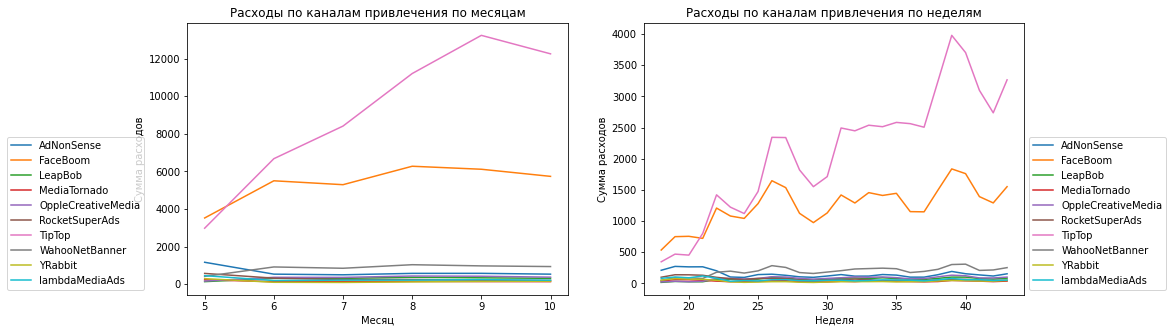

In [22]:
# выделяем месяц из общей даты
costs['dt_month'] = pd.to_datetime(costs['dt']).dt.month
# создаем таблицу динамики по месяцам
costs_marketing_month = (
     costs
     .pivot_table(index = 'dt_month', columns = 'channel', values='costs', aggfunc='sum')
 )
# визуализируем
ax1 = plt.subplot(1, 2, 1)
costs_marketing_month.plot(ax=ax1, figsize=(15,5))
plt.legend(bbox_to_anchor=(-0.1, 0.6))
plt.xlabel('Месяц')
plt.ylabel('Сумма расходов')
plt.title('Расходы по каналам привлечения по месяцам')

# выделяем недели из общей даты
costs['dt_week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

# создаем таблицу динамики по неделям
costs_marketing_week = (
     costs
     .pivot_table(index = 'dt_week', columns = 'channel', values='costs', aggfunc='sum')
 )
# визуализируем
ax2 = plt.subplot(1, 2, 2)
costs_marketing_week.plot(ax=ax2, figsize=(15,5))
plt.legend(bbox_to_anchor=(1, 0.6))
plt.xlabel('Неделя')
plt.ylabel('Сумма расходов')
plt.title('Расходы по каналам привлечения по неделям')
plt.show()


Явно выделяются две платформы, на которые потрачено польше всего средств: TipTop и FaceBoom, причем на графиках видно достаточно резкое повышение расходов на TipTop, особенно после 20 недели года. На графике по неделям мы видим резкие скачки и к понижению цены на обеих платформах.
Все остальные платформы сильных скачков в расходах не показывают - они достаточно постоянны. Но на платформе AdNonSense можно заметить снижение расходов после 20 недели.

Посмотрим сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [23]:
profiles_costs = (profiles
                  .groupby('channel')
                  .agg({'acquisition_cost':'mean'})
                  .sort_values(by='acquisition_cost', ascending=False))
profiles_costs.round(2)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Как и ожидалось самое дорогое привлечение пользователя у TipTop, далее FaceBoom и AdNonSense.

Уже сейчас смотря на эти показатели можно сказать, что одна из причин, по которой не окупается реклама, скорее всего в неудачной и слишком дорогой рекламе на нескольких платформах. Например, на платформу TipTop пришелся 51% расходов за весь период, там закупалась самая дорогая реклама, но конверсия пользователей там не на первом месте из всех платформ. 

Чтобы лучше разобраться в рекламе, обратимся к метрикам.

#### Графики LTV и ROI

  Посмотрим окупаемость рекламы c помощью когортного анализа, графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI. 
  
  Напоминаю, что данные, которые мы используем в анализе находятся в промежутке с 1 марта 2019 по 27 октября 2019. В качестве учебного задания считаем, что на календаре 1 ноября 2019 года - это будет наш момент анализа. А в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, это будет наш горизонт анализа, с помощью которого будут расчитываться когорты в заданных ранее функциях. 

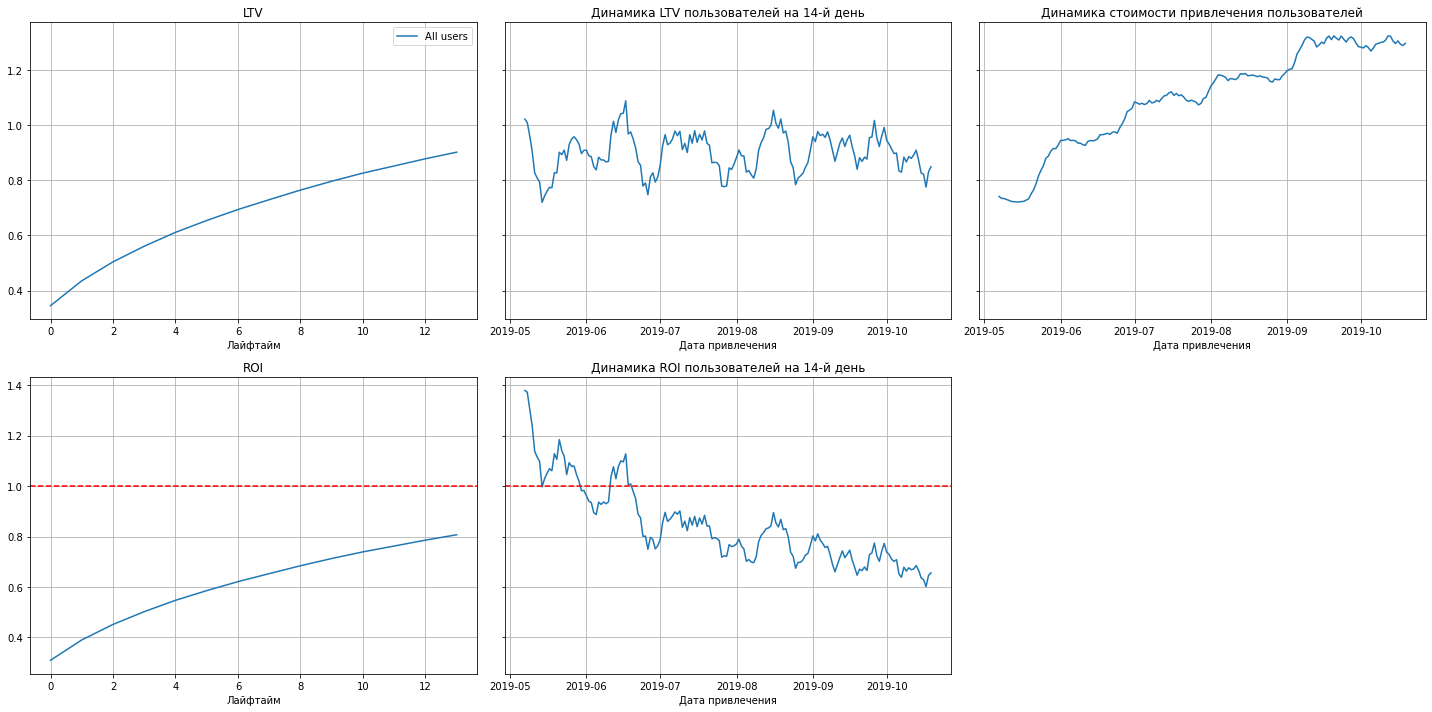

In [24]:
# горизонт анализа 
horizon_days = 14
# момент анализа
observation_date = datetime(2019, 11, 1).date()
# убираем органических пользователей
profiles_new = profiles.query('channel != "organic"')

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


- LTV повышается, значит расчеты верны.
- В динамике на 14-й день обычно в конце месяца есть спад LTV, скорее всего роль играет некая сезонность в приложении. Не считая скачков, динамика стабильна. В октябре LTV имела тенденцию к снижению.
- CAC в конце мая имеет резкий скачок - возросли расходы на рекламу. И далее к октябрю они продолжали повышаться. 
- CAC не окупается, ROI составляет около 80% к 14 дню жизни.


#### Графики конверсии и динамики конверсии

Проверим конверсию пользователей и динамику её изменения.

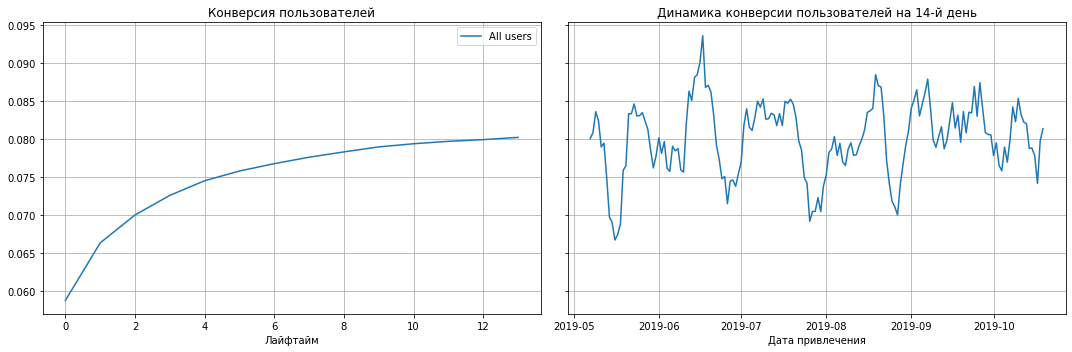

In [25]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=[]
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Общая конверсия повышается. К 14 дню она достигает 8 %.
- В мае был большой провал в конверсии на 14-й день. Затем в июне, июле и августе в конце месяца на 14 день жизни видим большие проседания конверсии. В сентябре и октябре таких больших провалов не наблюдается.


Посмотрим на конверсию по *странам*.

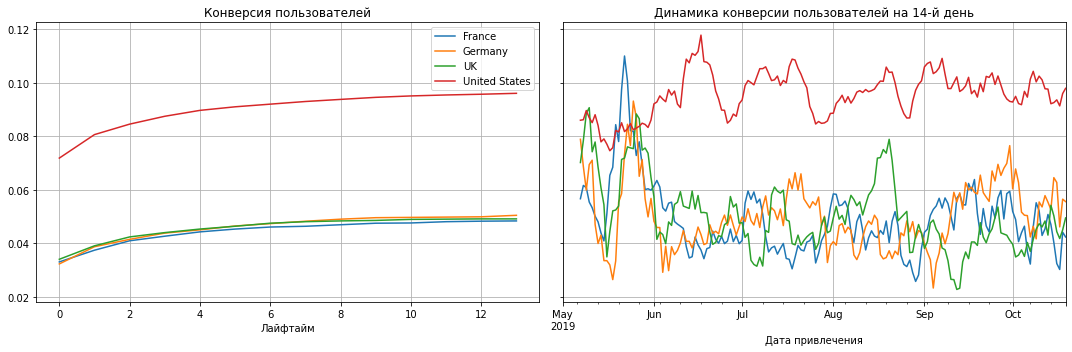

In [26]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Как мы раньше видели, лучше всего конвертируются пользователи из США (почти 10% к 14 дню), в Европе конверсия около 5% к этому же дню.
- Провал конверсии в мае на 14-й день, а затем большой скачок вверх, был именно у европейских стран.

Посмотрим на конверсию пользователей в разрезе *устройств*, которые они используют. 

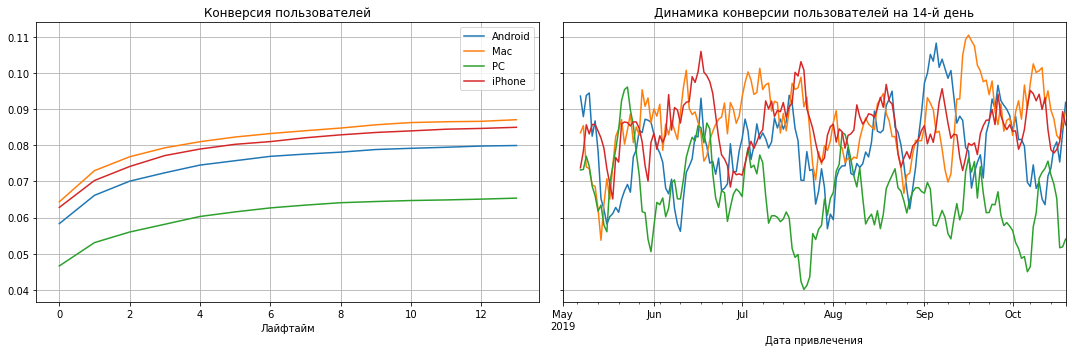

In [27]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Хуже всего конвертируются пользователи PC (6,5%).
- Пользователи iPhone и Mac более стабильны и лучше конвертируются (~8,7%). Не так далеко от них ушли пользователи Android (8%).
- Все пользователи имеют провал в конце мая (пользователи iPhone - чуть меньше)
- У пользователей PC на 14-й день есть два провала - в конце июля и начале октября.

Возможно PC версия приложения не совсем удачная. Хотя ранее мы видели, что доля платящих пользователей с PC самая высокая для Великобритании (4%).

Посмотрим на конверсию пользователей в разрезе *платформ*, откуда они приходят.

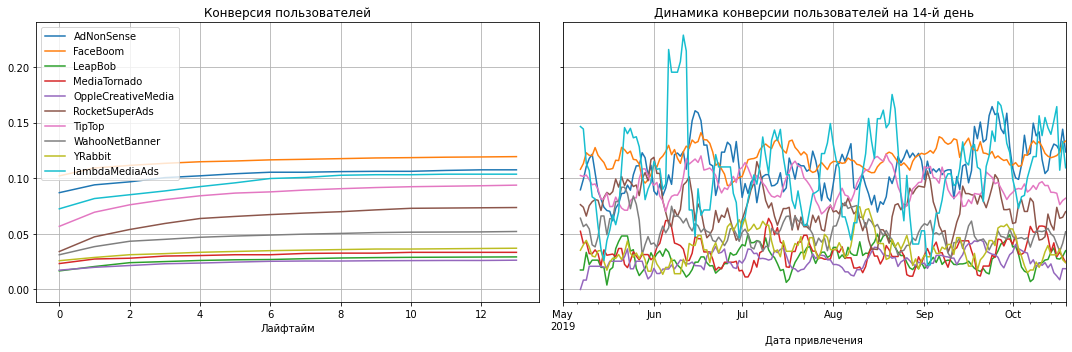

In [28]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Как ранее и говорилось большая конверсия у 4 платформ: FaceBoom, AdNonSense, lambdaMediaAds и TipTop.
- Кривые конверсии постоянны на протяжении почти всего лайфтайма.
- Почти у всех платформ конверсия стабильна на 14-й день - сильно выделляется платформа lambdaMediaAds.

Ради интереса посмотрим на конверсию *органических пользователей*.

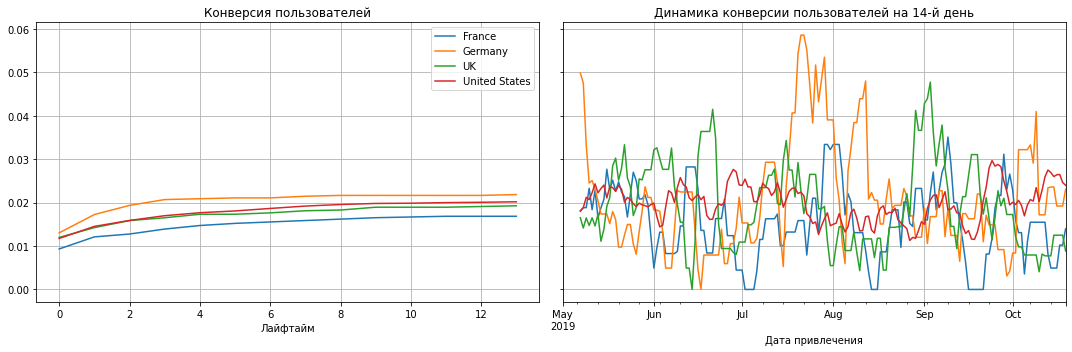

In [29]:
# фильтруем датасет
profiles_organic = profiles.query('channel == "organic"')
# создаем графики
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_organic, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Конверсия всего 2%, чуть лучше в Германии.

#### Графики удержания

Проверим удержание пользователей и его динамику. Сразу сделаем разбивку **по устройствам**.

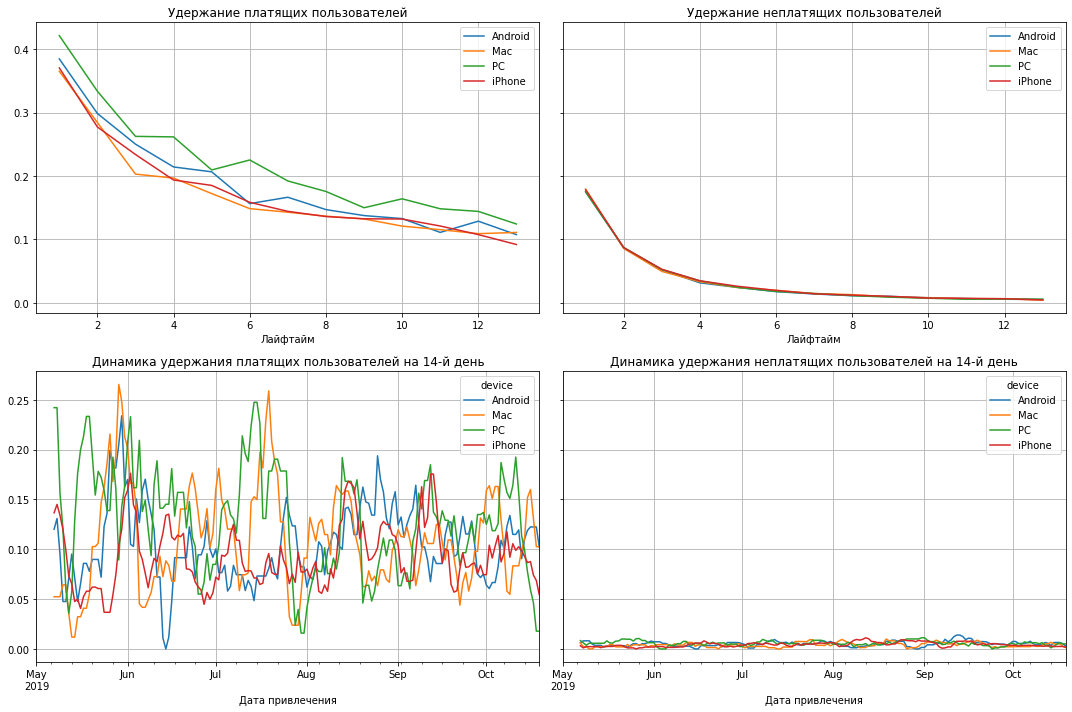

In [30]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Немного лучше остальных удерживаются пользователи с PC, хотя конверсия у этого устройства была самая низкая, затем Android.
- На 14-й день видим большие скачки в удержании почти для всех устройств: в мае кривые уходят вниз, а затемрезко вверх. В середине июня пользователи Android почти не удерживались (возможно была техническая ошибка)
- В конце октября на 14-й день резко падает удержание пользователей PC
- Динамика неплатящих пользователей стабильна.

Посмотрим на **удержание по странам**.

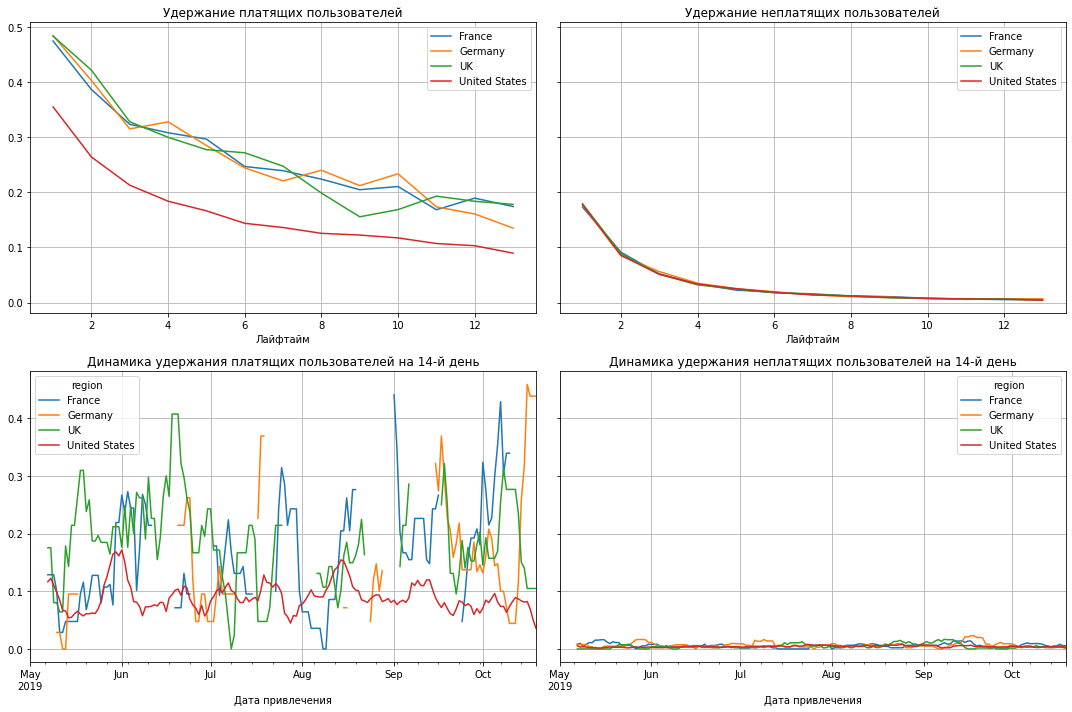

In [31]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Пользователи из США хуже всего удерживаются и на 14-й день имеют самые низкие значения, хотя имеют самую высокую конверсию.
- График динамики удержания прерывистый для некоторых стран - нет данных за некоторый период, скорее всего с этих платформ не приходили. 
- В мае есть общий скачок вниз у кривых динамики на 14-й день.
- В конце октября у Германии большой скачок вверх.

Посмотрим **удержание** с разбивкой **по каналам привлечения**.

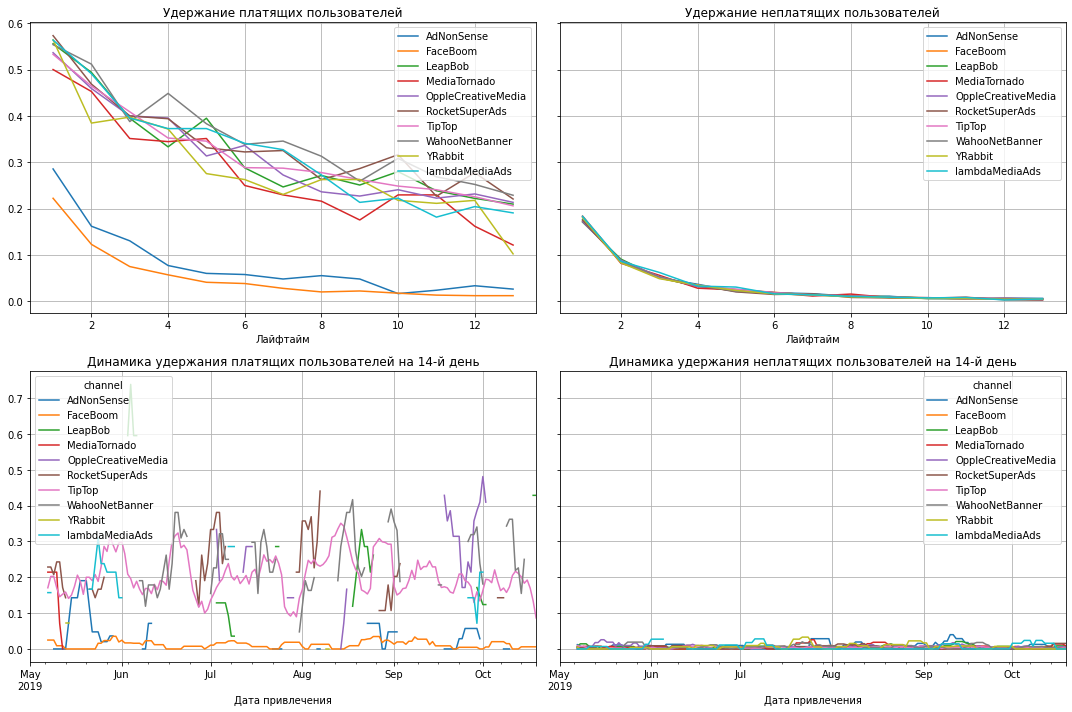

In [32]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- FaceBoom и AdNonSense имеют самое низкое удержание, остальные каналы примерно в одной динамике
- По прерывистости кривых динамики удержания на 14-й день, есть предположение, что реклама за весь период постоянно закупалась только в каналах TipTop и FaceBoom, так как только они имеют четкую динамику без перерывов, а для всех остальных платформ нет данных.
- TipTop, у которого дорогая реклама, по удержанию не выделяется. 
- Качество аудитории в разных каналах различается.


#### LTV и ROI с разбивкой по параметрам

Посмотрим окупаемость рекламы с разбивкой по **устройствам**.

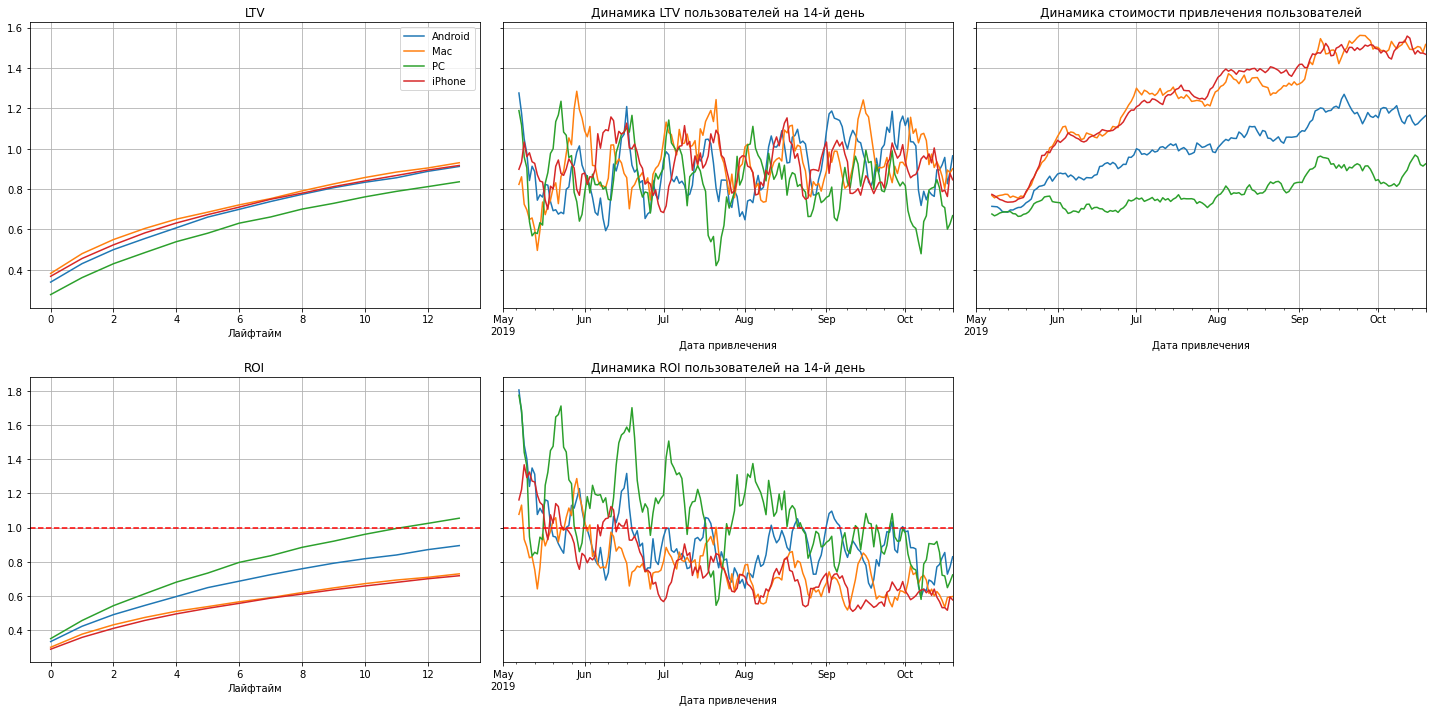

In [33]:
# считаем LTV и ROI с разбивкой по устройствам,
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


- LTV чуть ниже у пользователей PC, стоимость привлечения таких пользователей была ниже всех, у них была самая низкая конверсия, но самое высокое удержание. 
- Больше всех стоимость привлечения у Mac и iPhone. Видим резкое повышение CAC в середине мая из-за увеличения трат. 
- Пользователи с PC окупаются - примерно на 12 день, все остальные устройства - нет.
- ROI на 14 день для всех пользователей постепенно снижается для всех устройств. Выше уровня окупаемости дольше держатся пользователи PC.

Посмотрим на графики с разбивкой по **странам**.

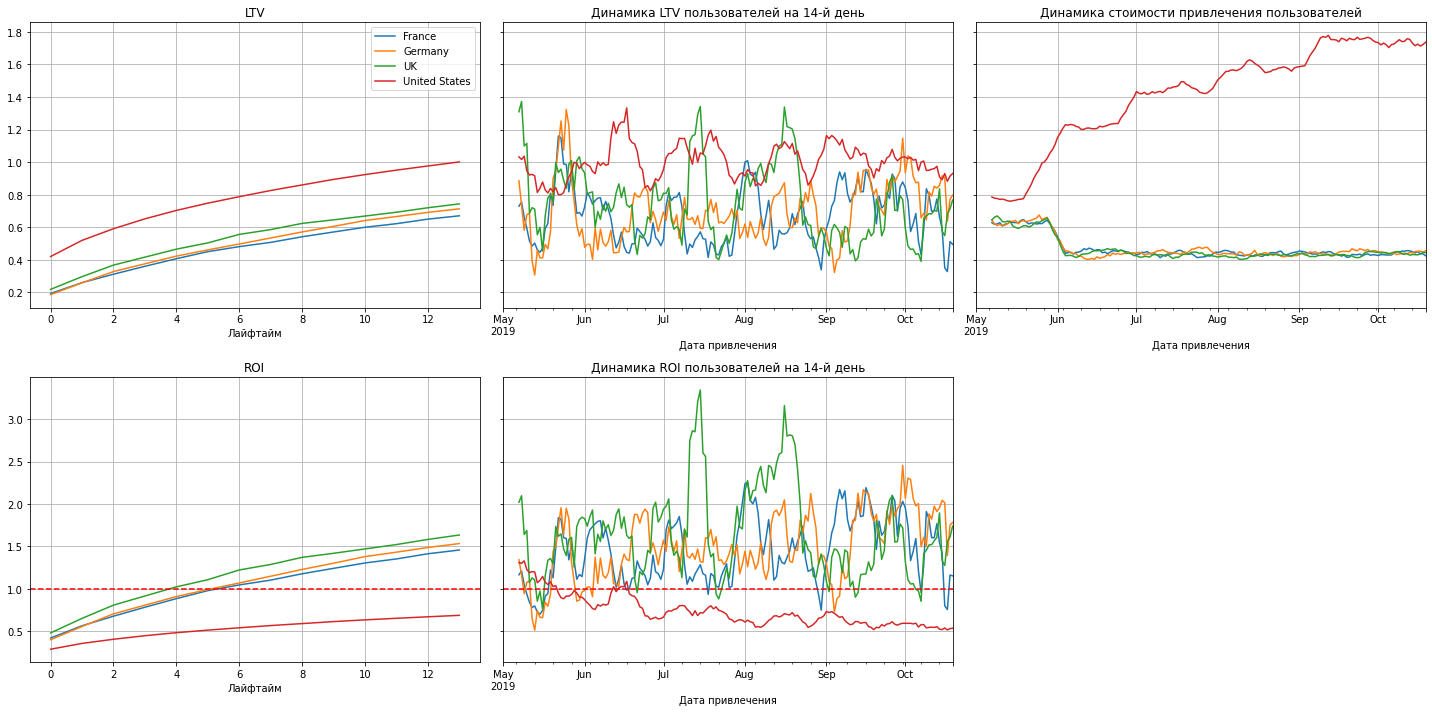

In [34]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- Несмотря на то, что пользователи из США приносят больше денег за свой лайфтайм, такие расходы на рекламу не окупаются. На 14-й день динамика ROI для США падает с середины мая за уровень окупаемости.
- CAC для остальных пользователей в конце мая-начале июня упал. То есть основные вложения были в рекламу для пользователей США
- ROI превышает уровень окупаемости у всех остальных стран примерно на 4-6 день. 
- Великобритания имеет большие всплески в графике динамике ROI на 14-й день.

Посмотрим на графики с разбивкой по **каналу привлечения**.

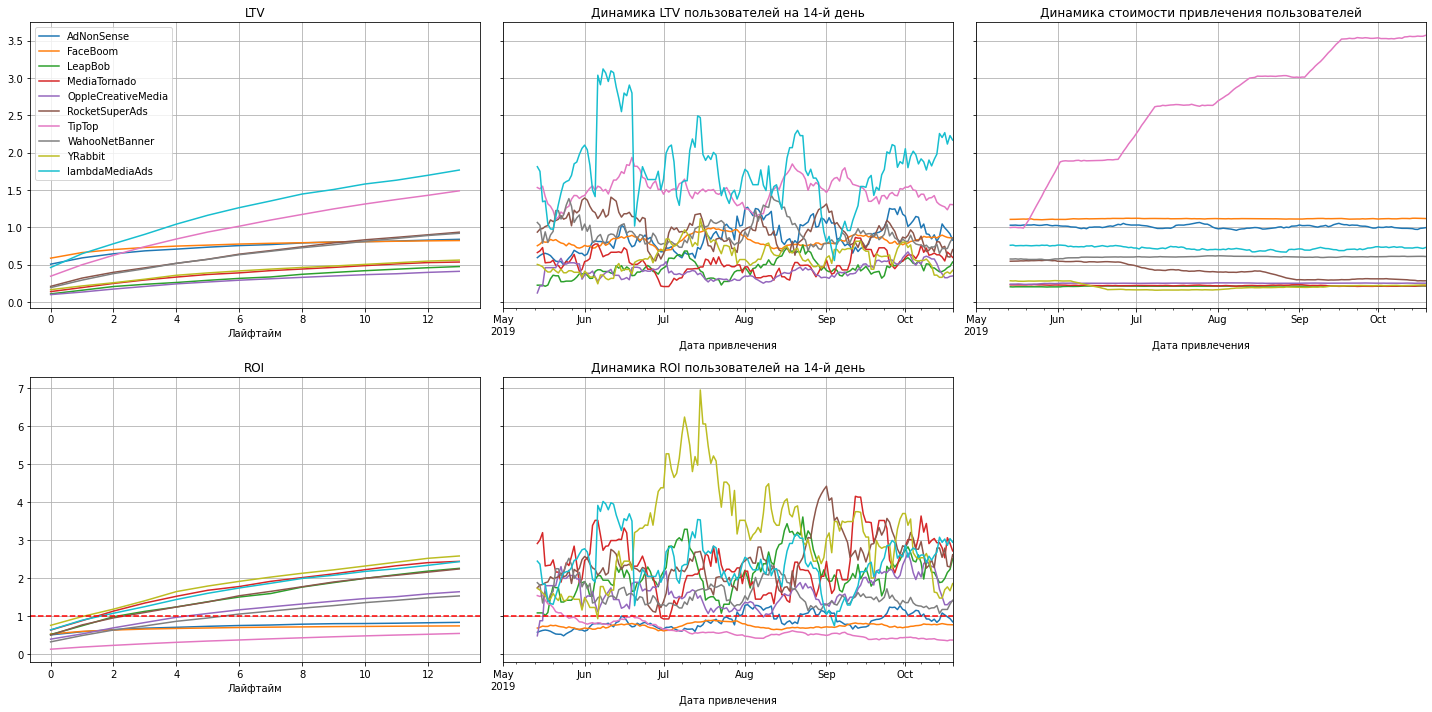

In [35]:
# считаем LTV и ROI с разбивкой по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- Выделяются LTV двух площадок: lambdaMediaAds и TipTop, пользователи FaceBoom имеют достаточно скромный LTV.
- Больше всего выросла стоимость привлечения пользователей на платформе TipTop, для остальных каналов САС стабилен. Именно эта платформа спровоцировала большой скачок трат на рекламу.
- На платформе FaceBoom закупалась одинаково дорогая и не эффективная реклама - ROI не пересекает уровень окупаемости.
- Уровень окупаемости в ROI проходят все платформы кроме: FaceBoom, TipTop и AdNonSense
- Хорошие показатели ROI и ROI в динамике на 14-й день показывают пользователи, привлеченные с платформы YRabbit, MediaTornado, lambdaMediaAds.
- В динамике ROI есть большой всплеск в июле на платформе YRabbit - именно она лидирует по окупаемости рекламы.

Проведем **дополнительный анализ** окупаемости рекламы отдельно для европейских стран и для США.

#### Метрики для США

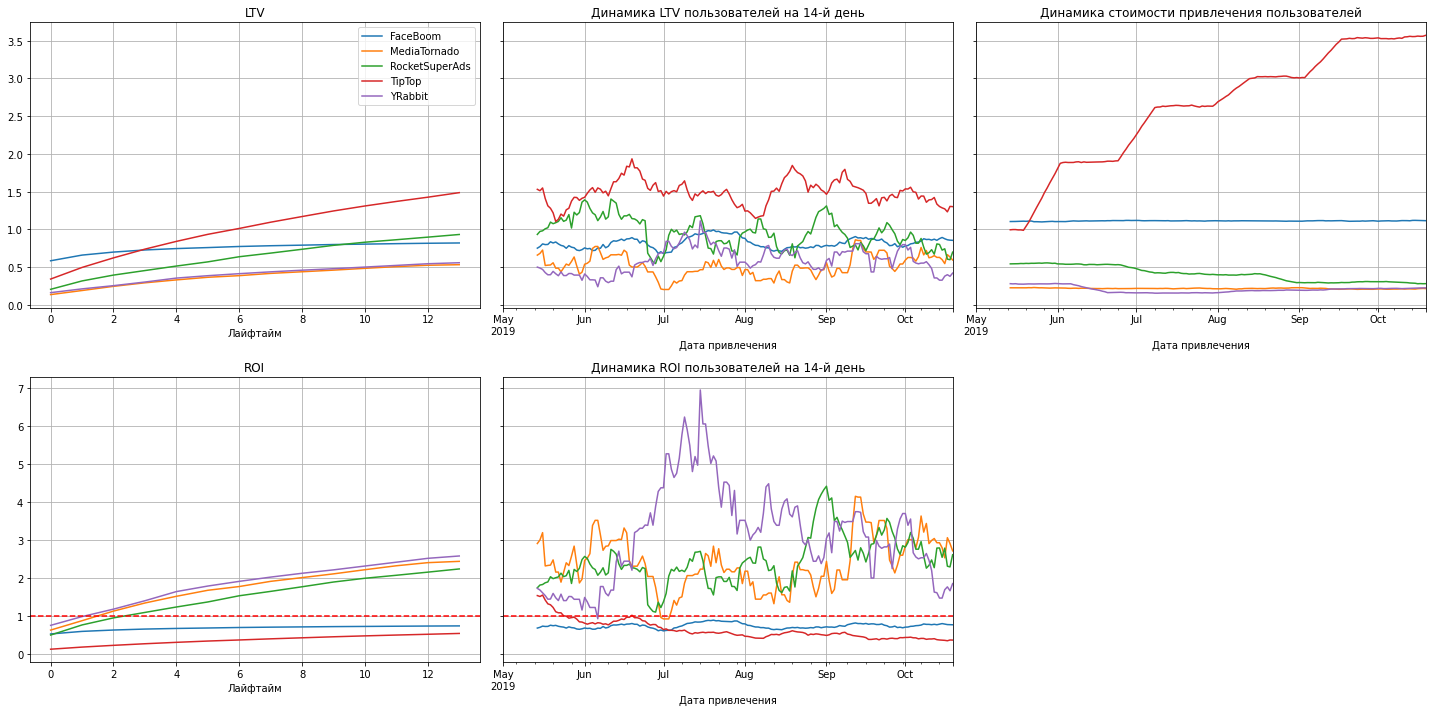

In [36]:
# фильтруем датасет
profiles_new_usa = profiles_new.query('region == "United States"')
# считаем LTV и ROI с разбивкой по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new_usa, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- LTV, динамика на 14-й день и CAC самые большие у TipTop. ROI не проходит уровень окупаемости.
- Перспективная платформа для привлечения пользователей: RocketSuperAds - неплохое удержание, хорошая конверсия к 14-му дню (около 7%), окупаемость больше 200%

По всем данным можно сделать вывод, что в TipTop закупалась реклама только для США

#### Метрики для европейских стран

Посмотрим *метрики* для стран **Европы** по каналам привлечения.

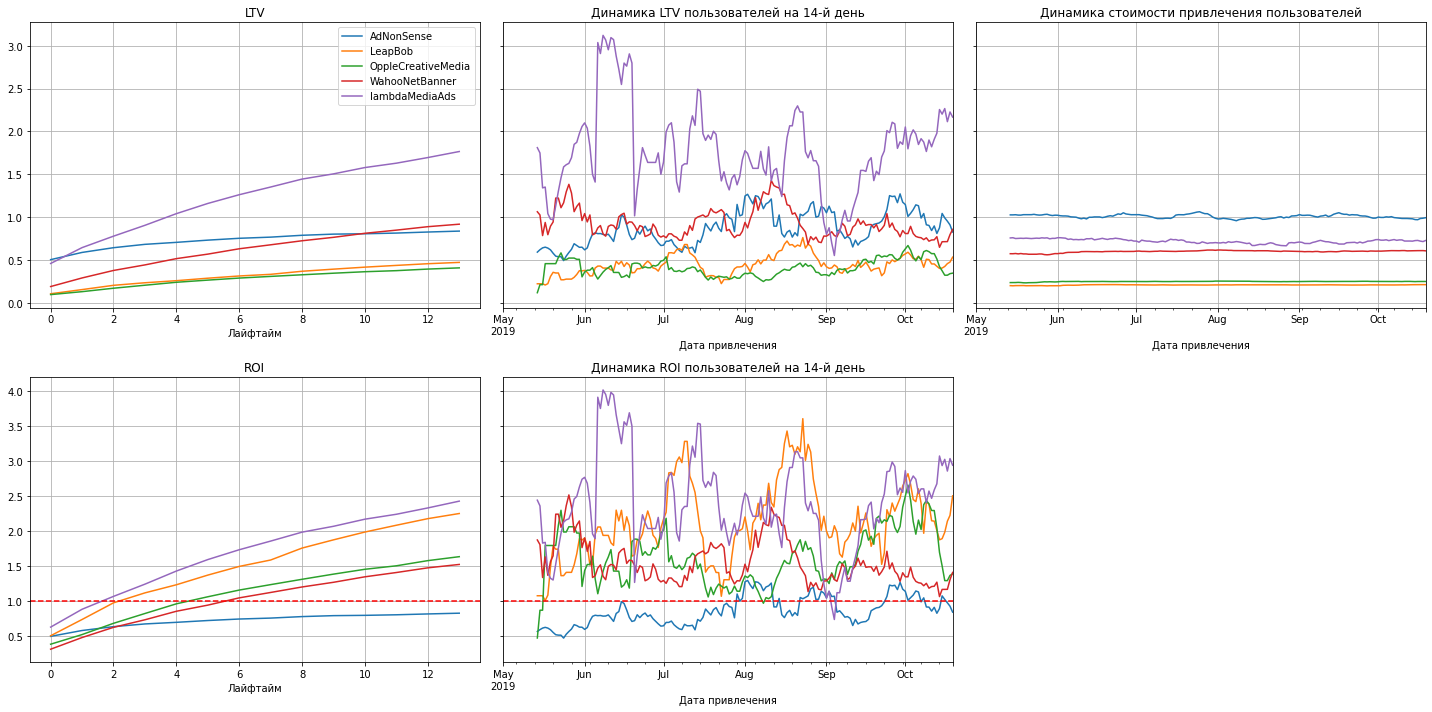

In [37]:
# фильтруем датасет
profiles_new_europe = profiles_new.query('region != "United States"')
# считаем LTV и ROI с разбивкой по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new_europe, orders, observation_date, horizon_days, dimensions=['channel']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- Реклама на платформе AdNonSense не окупается, хотя стремится к этому, здесь самый высокий CAC.
- Перспективная платформа для рекламы: lambdaMediaAds - хорошая конверсия и удержание, высокий LTV, окупаемость почти 170%

Посмотрим какие устройства лучше окупаются в Европе

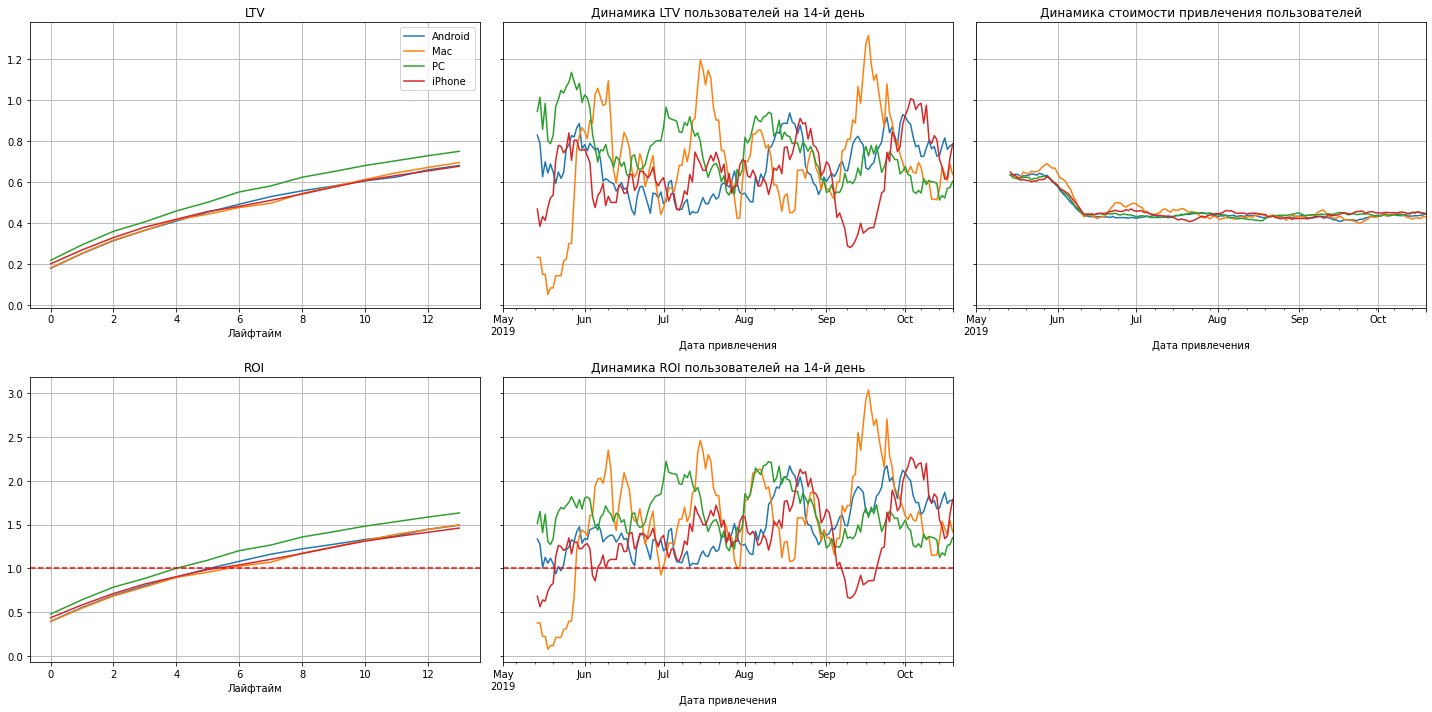

In [38]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new_europe, orders, observation_date, horizon_days, dimensions=['device']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- Немного выше LTV и ROI у пользователей с PC
- CAC у всех пользователей одинаковый
- Все устройства окупаются с 4-6 дня.
- Большой скачок вниз в динамике ROI на 14-й день в мае был как раз у пользователей Mac, а пользователи iPhone единственные падали за границу окупаемости.

Промежуточные итоги: 
1. Реклама в целом не окупается.
2. Негативное влияние на окупаемость могут оказывать: устройства - Mac и iPhone (хорошая конверсия, не окупаются, дорогая стоимость привлечения), страна - США (хороший LTV, дорогая стоимость привлечения в динамике, не окупаются), рекламные каналы - TipTop (не окупается, самая высокая стоимость рекламы) и FaceBoom (хорошая конверсия, плохое удержание).
3. Проблемы окупаемости могут быть связаны с большим вкладом в рекламу для привлечения пользователей только из одной страны и только на одной-двух платформах (США, TipTop, FaceBoom).

### Выводы

В ходе исследования проанализированы данные с 1 мая 2019 по 27 октября 2019 о 150008 пользователях.

- Реклама в целом не окупается (по кривым ROI), но в разрезе по странам, в районе неокупаемости находится только США. 
- CAC на протяжении всего периода только возрастала, так как возрастали затраты на рекламу. Общий ROI на 14 день только снижался.
- Общая конверсия неплатящих пользователей в платящих - 8%.
- В удержании хуже всего себя показали страна  США и рекламные платформы: FaceBoom и AdNonSense.

Откуда сейчас приходят основные платящие пользователи:

- Основной процент платящих пользователей приходит из США (77,7%), там же самая высокая конверсия и высокий LTV, но при этом самое низкое удержание, высокая стоимость привлечения и как следствие *низкий уровень окупаемости ROI*.

- 38,1% платящих пользователей используют iPhone, у этих пользователей высокая конверсия, LTV чуть выше остальных устройств, удержание чуть ниже, чем у других платформ, высокая CAC и *низкий уровень окупаемости ROI*. 

- 40.1% пользователей приходит в платформы FaceBoom, 21.1% c платформы TipTop. На них приходится почти 83% рекламного бюджета за исследуемый период. FaceBoom немного выигрывает у других платформ в конверсии (12%), но в целом выдающихся показателей у них нет. У FaceBoom низкое удержание, у TipTop высокая растущая CAC. *ROI у обеих платформ не окупается*. 

Причины неэффективности привлечения пользователей:

- Концентрация большей части рекламного бюджета (83%) только на двух платформах, приносящих большое количество некачественных пользователей и имеющих дорогую рекламу.
- Привлечение пользователей в основном из США.
- Привлечение пользователей на Mac и iPhone.

Рекомендации для отдела маркетинга:

- На будущее проводить регулярный анализ рекламной кампании для возможности быстро реагировать на обстоятельства.
- Прекратить закупать дорогостоящую рекламу в TipTop и FaceBoom (может есть возможности изменить тип закупки рекламы), обратить внимание на платформы с хорошими показателями ROI, конверсии и удержания. 
        - Альтернативная платформа для США:
               - RocketSuperAds - неплохое удержание, хорошая конверсия к 14-му дню (около 7%), окупаемость больше 200%.
        - Альтернативная платформа для стран Европы:
               - lambdaMediaAds - хорошая конверсия и удержание, высокий LTV.

- Обратить внимание на европейский рынок: особенно англоязычные страны. Развитие рынка в уже реализуемой стране - Великобритании (сейчас 7.9% от платящих пользователей, самый быстрый переход в зону окупаемости). Это не потребует разработки интерфейса на другом языке. 
- Обратить внимание на версии приложения для PC - лучше всего окупается в Европе, с Android была самая лучшая конверсия у США - 7%

